In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf

In [3]:
# Activity mapping
Activity_Types = {'dws':1, 'jog':2, 'sit':3, 'std':4, 'ups':5, 'wlk':6}
Activity_Labels = list(Activity_Types.keys())

# Define folder path
data_folder = "A_DeviceMotion_data"
Folders = glob(f'{data_folder}/*_*')
Folders = [s for s in Folders if "csv" not in s]

Df_all_list = []
Exp = 0
Segment_Size = 400  # Segment the data into 400-sample frames

# Load all data
for j in Folders:
    Csv = glob(j + '/*')

    for i in Csv:
        df = pd.read_csv(i)
        
        # Add activity label, subject name, and experiment number
        df['Activity'] = Activity_Types[j[len(data_folder)+1:len(data_folder)+4]]
        df['Sub_Num'] = i[len(j)+1:-4]
        
        ExpNum = np.zeros((df.shape[0]))
        for k in range(0, df.shape[0] - Segment_Size, Segment_Size):
            ExpNum[range(k, k + Segment_Size)] = k / Segment_Size + Exp * 100
        df['Exp_num'] = ExpNum

        Df_all_list.append(df)
        Exp += 1

# Concatenate all data
Df_all = pd.concat(Df_all_list, axis=0)

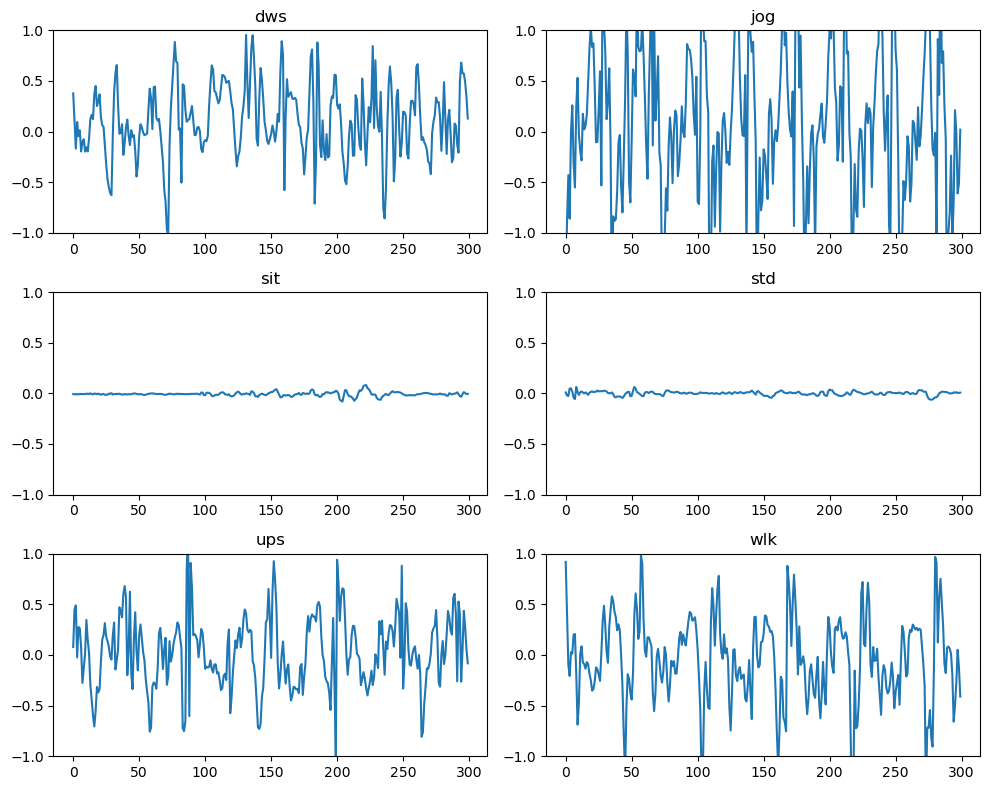

In [4]:
activity_names  = ['dws', 'jog', 'sit', 'std', 'ups', 'wlk']

plt.figure(figsize=(10, 8))

for i in range(6):
    D = Df_all[Df_all['Activity'] == i+1]
    plt.subplot(3, 2, i+1)
    plt.plot(D['userAcceleration.z'][:300])
    plt.title(activity_names[i])
    plt.ylim([-1, 1])

plt.tight_layout()
plt.show()

In [17]:
num_cols = Df_all.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('Exp_num')  # don't include group key in calculations

# Mean
df_sum = Df_all.groupby('Exp_num')[num_cols].mean().reset_index()
df_sum.columns = ['Exp_num'] + [col.replace('.', '_') + '_mean' for col in num_cols]

# Median of squares
df_sum_SS = Df_all[num_cols].pow(2).groupby(Df_all['Exp_num']).median().reset_index()
df_sum_SS.columns = ['Exp_num'] + [col.replace('.', '_') + '_median_sq' for col in num_cols]

# Max
df_max = Df_all.groupby('Exp_num')[num_cols].max().reset_index()
df_max.columns = ['Exp_num'] + [col.replace('.', '_') + '_max' for col in num_cols]

# Min
df_min = Df_all.groupby('Exp_num')[num_cols].min().reset_index()
df_min.columns = ['Exp_num'] + [col.replace('.', '_') + '_min' for col in num_cols]

# Skew
df_skew = Df_all.groupby('Exp_num')[num_cols].skew().reset_index()
df_skew.columns = ['Exp_num'] + [col.replace('.', '_') + '_skew' for col in num_cols]

# Std
df_std = Df_all.groupby('Exp_num')[num_cols].std().reset_index()
df_std.columns = ['Exp_num'] + [col.replace('.', '_') + '_std' for col in num_cols]

In [18]:
# Concatenate features (your original code)
Df_Features = pd.concat([
    df_max,
    df_sum[df_sum.columns[2:-2]],
    df_min[df_min.columns[2:-2]],
    df_sum_SS[df_sum_SS.columns[2:-2]],
    df_std[df_std.columns[2:-2]],
    df_skew[df_skew.columns[2:-2]]
], axis=1)

# Drop columns if they exist
cols_to_drop = [col for col in ['Exp_num', 'Unnamed: 0', 'Activity', 'Sub_Num'] if col in Df_Features.columns]
Df_Features_1 = Df_Features.drop(cols_to_drop, axis=1)

# Get labels from original data grouped by Exp_num
Labels = Df_all.groupby('Exp_num')['Activity'].first().values

Class_Num = len(Activity_Types)  # Number of activity classes

# Convert labels to zero-based indexing
Labels_zero_based = Labels - 1

In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(Df_Features_1, Labels_zero_based, test_size=0.25, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-hot encode labels
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=Class_Num)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=Class_Num)

# Build model with Input layer and two hidden layers
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(Df_Features_1.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(Class_Num, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9967 - loss: 0.0151 - val_accuracy: 0.9980 - val_loss: 0.0033
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0100 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9980 - loss: 0.0094 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0070 - val_accuracy: 0.9980 - val_loss: 0.0029
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0054 - val_accuracy: 0.9980 - val_loss: 0.0031
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9981 - loss: 0.0081 - val_accuracy: 0.9980 - val_loss: 0.0030
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0106 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0083 - val_accuracy: 0.9980 - val_loss:

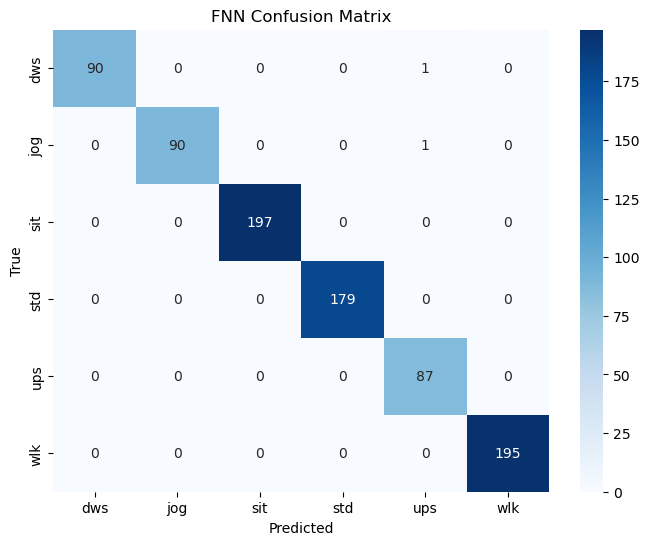

In [21]:
# Train model
history = model.fit(X_train_scaled, y_train_oh, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=[early_stop])

# Evaluate
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_oh, verbose=2)
print(f'Test accuracy: {test_acc:.4f}')

# Predict classes
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix and accuracy
conf_mat = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print("Confusion Matrix:\n", conf_mat)
print(f"Accuracy (sklearn): {acc:.4f}")

# Plot confusion matrix function
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('FNN Confusion Matrix')
    plt.show()

# Plot it
plot_confusion_matrix(conf_mat, activity_names)

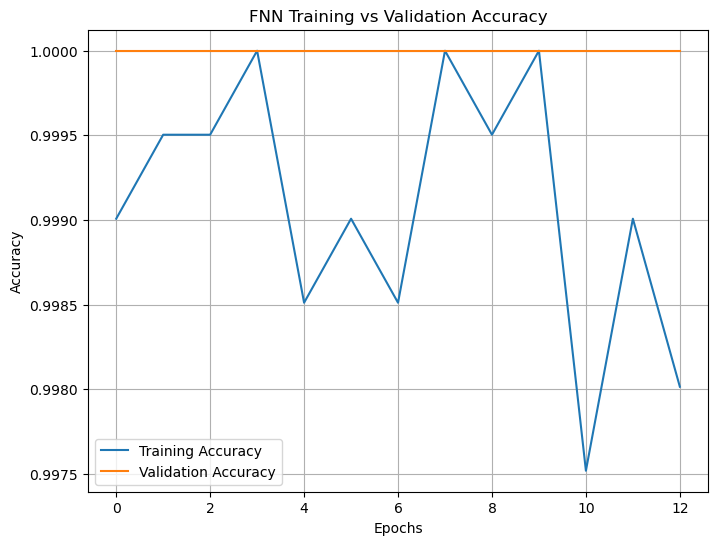

In [16]:
# Plot training vs validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('FNN Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
